# **10 Model GradientBoostingRegressor**

## Objectives

* Apply appropriate ML methods (regression/classification/clustering). Evaluate with relevant metrics. Compare approaches
* GradientBoostingRegressor

## Inputs

* housing_cleaned-geo.csv

## Outputs

* GradientBoostingRegressor_set.csv
* GradientBoostingRegressor_model.pkl


---

# GradientBoostingRegressor model

Import packages

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 


In [21]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned-geo.csv')


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249 entries, 0 to 7248
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction                   7248 non-null   object 
 1   price                         7248 non-null   float64
 2   transfer_date                 7248 non-null   object 
 3   postcode                      7248 non-null   object 
 4   property_type                 7248 non-null   object 
 5   new_build                     7248 non-null   float64
 6   tenure                        7248 non-null   object 
 7   PAON                          7248 non-null   object 
 8   SAON                          371 non-null    object 
 9   Street                        7219 non-null   object 
 10  Locality                      3020 non-null   object 
 11  town_city                     7248 non-null   object 
 12  district                      7248 non-null   object 
 13  cou

---

The ruc21 values refer to the Rural Urban Classification (RUC) codes which categorize each area as urban or rural based on population and settlement characteristics. Examples from your data include UNI, RUN1, RSNI, UF1, etc.

- UN1: Urban city and town
- RLN1: Rural town and fringe
- RSN1: Rural village
- UF1: Urban major conurbation
- RLF1: Rural hamlet and isolated dwellings
- RSF1: Rural hamlet and isolated dwellings in a sparse setting

In [23]:
df['ruc21'].value_counts()

ruc21
UN1     5888
RLN1     622
RSN1     469
UF1      131
RLF1      70
RSF1      68
Name: count, dtype: int64

In [24]:
# convert to datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]

In [26]:
# set model features
num_feats   = ['log_total_floor_area','IMD_Rank','energy_band_num']
bin_feats   = ['new_build','is_leasehold']  # pass through as 0/1
cat_feats   = ['property_type','county','ruc21']  # one-hot encode

# Control category order to set baselines via drop='first'
ptype_order = ['D','S','T','F']  # baseline becomes 'D' (Detached)
county_order = [
    'WEST MIDLANDS','WARWICKSHIRE','WORCESTERSHIRE','LEICESTERSHIRE',
    'LEICESTER','STAFFORDSHIRE','DERBYSHIRE','CITY OF DERBY','STOKE-ON-TRENT'
 ]  # baseline becomes WEST MIDLANDS
ruc21_order = ['UN1','UF1','RLN1','RSN1','RLF1','RSF1']  # baseline becomes UN1 (Urban city and town)

# Build the ColumnTransformer (code supported by Copilot)
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order, county_order, ruc21_order],
                              handle_unknown='ignore'),
         cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
 )

# End-to-end pipeline
pipeline = Pipeline([
    ('pre', pre),
    ('model', GradientBoostingRegressor(random_state=101))
])

X = df[num_feats + cat_feats + bin_feats]
y = df['log_price']  # log price to reduce skew

# Test using the most recent 20% of the data as the test set
# Use a sorted split based on date
df = df.sort_values(by='transfer_date').reset_index(drop=True)
# split index at 80%
split_index = int(len(df) * 0.8)
print(f"Split index: {split_index}, Total records: {len(df)}")
print(f"Date at split index: {df.iloc[split_index]['transfer_date']}")

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# separate target variable
y_train = train_df['log_price']
y_test = test_df['log_price']
X_train = train_df.drop(columns=['log_price'])
X_test = test_df.drop(columns=['log_price'])

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
# fit the pipeline
pipeline.fit(X_train, y_train)


Split index: 5667, Total records: 7084
Date at split index: 2025-08-01 00:00:00
* Train set: (5667, 50) (5667,) 
* Test set: (1417, 50) (1417,)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_total_floor_area',
                                                   'IMD_Rank',
                                                   'energy_band_num']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[['D',
                                                                             'S',
                                                                             'T',
                                                                             'F'],
                                                                            ['WEST '
                                                                             'MIDLANDS',
                                                                             'WARWICKSHIRE',
                                                                             'WORCESTERSHIRE',
                                                                             'LEICESTERSHIRE',
                                                                             'LEICESTER',
                                                                             'STAFFORDSHIRE',
                                                                             'DERBYSHIRE',
                                                                             'CITY '
                                                                             'OF '
                                                                             'DERBY',
                                                                             'STOKE-ON-TRENT'],
                                                                            ['UN1',
                                                                             'UF1',
                                                                             'RLN1',
                                                                             'RSN1',
                                                                             'RLF1',
                                                                             'RSF1']],
                                                                drop='first',
                                                                handle_unknown='ignore'),
                                                  ['property_type', 'county',
                                                   'ruc21']),
                                                 ('bin', 'passthrough',
                                                  ['new_build',
                                                   'is_leasehold'])])),
                ('model', GradientBoostingRegressor(random_state=101))])

### Note:
- The following feature_importance_tree_based_models custom function was provided by the Code Institute for their Data Analysis with AI course.

In [27]:
def feature_importance_tree_based_models(model, columns):
  """
  Gets the model and the columns used to train the model
  - We use the model.feature_importances_ and columns to make a
  DataFrame that shows the importance of each feature
  - Next, we print the feature name and its relative importance order,
  followed by a barplot indicating the importance

  """

  # create DataFrame to display feature importance
  df_feature_importance = (pd.DataFrame(data={
      'Features': columns,
      'Importance': model.feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

  best_features = df_feature_importance['Features'].to_list()

  # Most important features statement and plot
  print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

  df_feature_importance.plot(kind='bar',x='Features',y='Importance')
  plt.show()


def get_feature_names_from_preprocessor(preprocessor):
    """Return feature names for each transformer within a fitted ColumnTransformer."""
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder' or transformer == 'drop':
            continue
        if transformer == 'passthrough':
            feature_names.extend(columns)
            continue
        fitted_transformer = transformer
        # Pipelines expose the final estimator through steps[-1]
        if hasattr(transformer, 'steps') and len(transformer.steps) > 0:
            fitted_transformer = transformer.steps[-1][1]
        if hasattr(fitted_transformer, 'get_feature_names_out'):
            try:
                names = fitted_transformer.get_feature_names_out(columns)
            except TypeError:
                names = fitted_transformer.get_feature_names_out()
        else:
            names = columns
        feature_names.extend(list(names))
    return feature_names

* These are the 21 most important features in descending order. The model was trained on them: 
['log_total_floor_area', 'IMD_Rank', 'property_type_F', 'property_type_T', 'property_type_S', 'county_STOKE-ON-TRENT', 'county_DERBYSHIRE', 'new_build', 'energy_band_num', 'ruc21_RSN1', 'county_STAFFORDSHIRE', 'county_LEICESTERSHIRE', 'county_WARWICKSHIRE', 'county_CITY OF DERBY', 'county_WORCESTERSHIRE', 'ruc21_RSF1', 'county_LEICESTER', 'ruc21_RLN1', 'ruc21_UF1', 'ruc21_RLF1', 'is_leasehold']


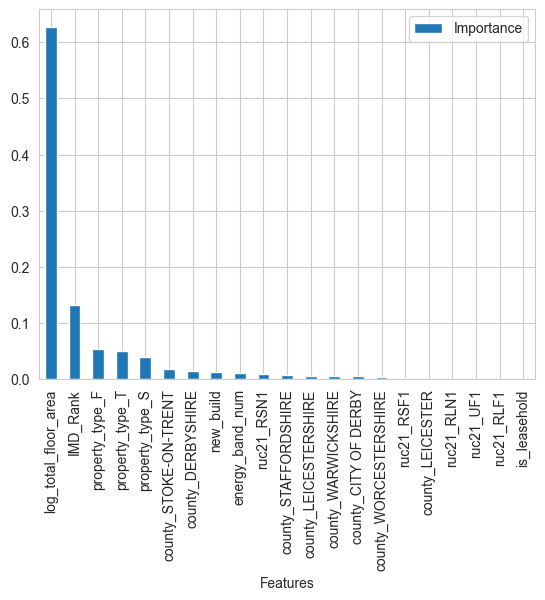

In [28]:
feature_names = get_feature_names_from_preprocessor(pipeline['pre'])
feature_importance_tree_based_models(model=pipeline['model'],
                                     columns=feature_names)

# Evaluate the model

In [29]:
# import regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
# we will use numpy to calculate RMSE based on MSE (mean_squared_error)
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test,pipeline):
  """
  # Gets train/test sets and pipeline and evaluates the performance
  - for each set (train and test) call regression_evaluation()
  which will evaluate the pipeline performance
  """

  print("Model Evaluation \n")
  print("* Train Set")
  regression_evaluation(X_train,y_train,pipeline)
  print("* Test Set")
  regression_evaluation(X_test,y_test,pipeline)



def regression_evaluation(X,y,pipeline):
  """
  # Gets features and target (either from train or test set) and pipeline
  - it predicts using the pipeline and the features
  - calculates performance metrics comparing the prediction to the target
  """
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  """
  # Gets Train and Test set (features and target), pipeline, and adjust dots transparency 
  at scatter plot
  - It predicts on train and test set
  - It creates Actual vs Prediction scatterplots, for train and test set
  - It draws a red diagonal line. In theory, a good regressor should predict
  close to the actual, meaning the dot should be close to the diagonal red line
  The closer the dots are to the line, the better

  """
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.726
Mean Absolute Error: 0.171
Mean Squared Error: 0.053
Root Mean Squared Error: 0.231


* Test Set
R2 Score: 0.743
Mean Absolute Error: 0.175
Mean Squared Error: 0.055
Root Mean Squared Error: 0.234




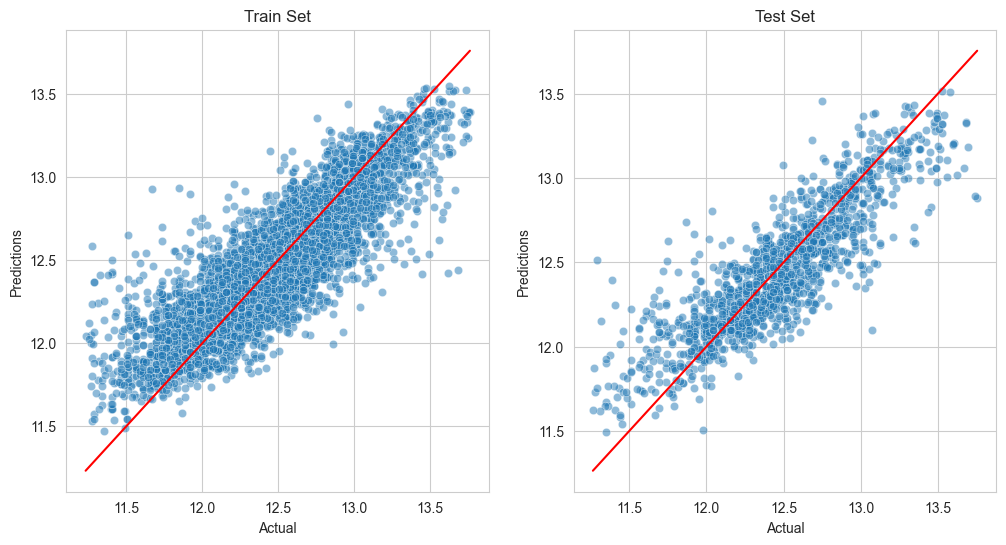

In [30]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

In [31]:
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


The train set Mean Absolute Error in GBP: 47,281
The test  set Mean Absolute Error in GBP: 49,354


**Note:**
- Train Set R2 Score: 0.726 Mean Absolute Error: £47,281
- Test  Set R2 Score: 0.743 Mean Absolute Error: £49,354

We have a model that generalises: the performance, the R2 and MAE for the train and sets are very similar. This is reinforced by the the actual vs predictions plots where we can see that the predictions are close to the actual prices for the train set compared to the test set.

Regression Model Performance 
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.726
Mean Absolute Error: 0.171
Mean Squared Error: 0.053
Root Mean Squared Error: 0.231


* Test Set
R2 Score: 0.743
Mean Absolute Error: 0.175
Mean Squared Error: 0.055
Root Mean Squared Error: 0.234


The train set Mean Absolute Error in GBP: 47,281
The test  set Mean Absolute Error in GBP: 49,354


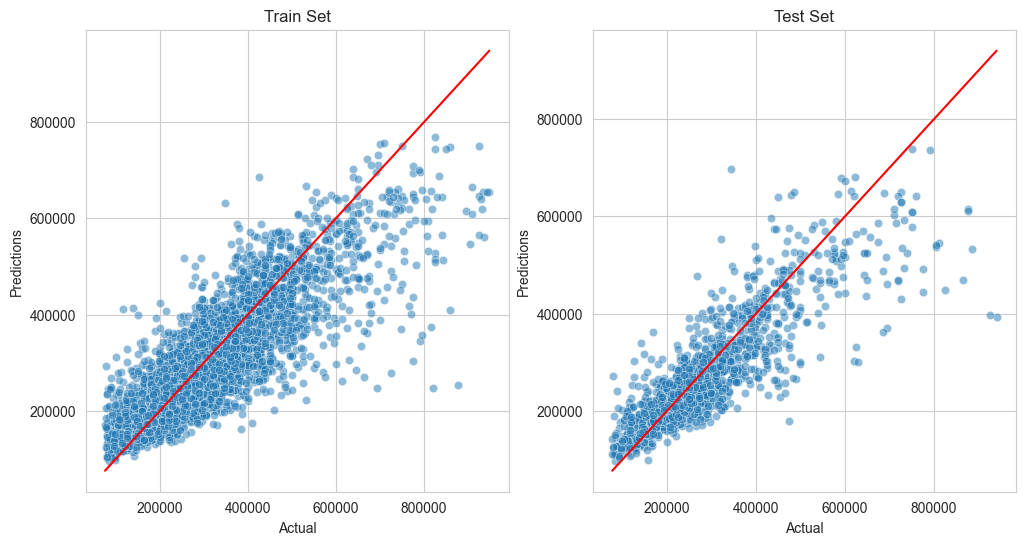

In [34]:
print("Regression Model Performance \nNote the MAE and MSE are in log(GBP) not GBP")
regression_performance(X_train, y_train, X_test, y_test, pipeline)

alpha_scatter=0.5
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.scatterplot(x=y_train_gbp, y=y_pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train_gbp, y=y_train_gbp, color="red", ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test_gbp, y=y_test_gbp, color="red", ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.show()


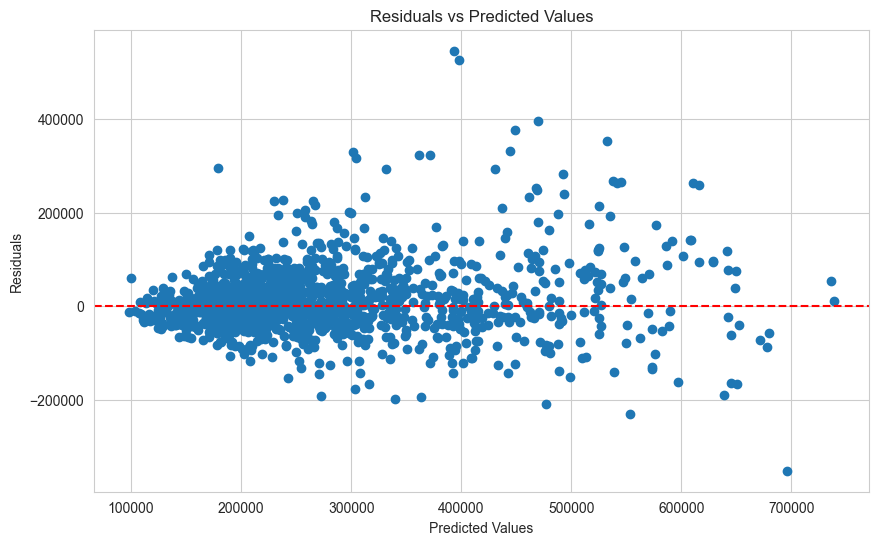

In [35]:
# plot the residuals
residuals = y_test_gbp - y_pred_gbp
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gbp, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

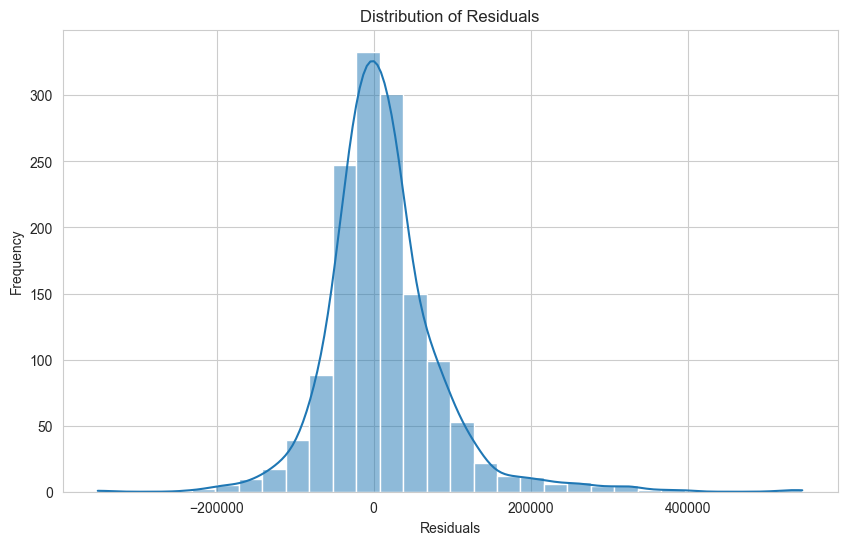

In [36]:
# what is the distribution of the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [37]:
# Save in a csv for analysis in Tableau
# merge X_train, X_test, y_train_gbp and y_test_gbp into a single dataframe
to_save = pd.concat([X_train, X_test], axis=0)
predicted_price = pd.concat([
    pd.Series(y_pred_train, name="predicted_price"),
    pd.Series(y_pred_gbp, name="predicted_price")
], axis=0)
to_save = pd.concat([
    to_save.reset_index(drop=True), 
    predicted_price.reset_index(drop=True), 
], axis=1)
# rename columns
to_save = to_save.rename(columns={"y_train_gbp": "actual_price_gbp", "y_test_gbp": "actual_price_gbp", "y_pred_train": "predicted_price_gbp", "y_pred_gbp": "predicted_price_gbp"})


In [38]:
# fix the is_leasehold and is_flat columns to be boolean
to_save['is_leasehold'] = to_save['tenure']=='L'
to_save['is_flat'] = to_save['property_type']=='F'
# is_flat_leasehold
to_save['is_flat_leasehold'] = to_save['is_flat'] & to_save['is_leasehold']

# drop columns with all missing values
to_save = to_save.dropna(axis=1, how='all')

# Save the full set for testing with other models

In [39]:
to_save.to_csv('../data/processed/GradientBoostingRegressor_set.csv', index=False)

In [40]:
import joblib
joblib.dump(value=pipeline , filename="GradientBoostingRegressor_model.pkl")

['GradientBoostingRegressor_model.pkl']

### Conclusions 
**Summary:**


| Dataset | R² | MAE  | Insights |
| --- | --- | --- | --- |
| Train | 0.726 | £47,281 | Predictions align closely with actuals, indicating strong fit without severe overfitting. |
| Test | 0.743 | £49,354 | Similar performance to training. |

- The residuals distribution is approximately normal, centered around zero, and some outliers in both tails.

- The results suggest good generalisation of the GradientBoostingRegressor model.


---